In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import numpy as np

In [4]:
client_data = "../data/clean/clean_client_data.csv"
analysis_data = "../data/clean/removed_outliers_data.csv"


In [5]:
client_df = pd.read_csv(client_data)
analysis_df = pd.read_csv(analysis_data)


In [6]:
analysis_df[analysis_df['step_proceeds']==True].pivot_table(index='process_step',
                                                            columns='Variation',
                                                            values=['step_duration'],
                                                            aggfunc='mean').round(2)

step_duration       
Variation          Control   Test
process_step                     
start                21.07  11.72
step_1               25.02  28.58
step_2               72.49  70.71
step_3               86.53  73.40

In [7]:
analysis_df.pivot_table(index='process_step',
                        columns='Variation',
                        values=['step_proceeds'],
                        aggfunc='mean').round(2)

step_proceeds      
Variation          Control  Test
process_step                    
confirm               0.00  0.00
start                 0.64  0.66
step_1                0.77  0.76
step_2                0.83  0.80
step_3                0.70  0.75

In [8]:
def successful_visit_col(df=analysis_df):
    analysis_df = df.copy()
    start_visit_ids = list(analysis_df[(analysis_df['process_step'] == 'start') & (analysis_df['step_proceeds'] == True)]['visit_id'])
    step_1_visit_ids = list(analysis_df[(analysis_df['process_step'] == 'step_1') & (analysis_df['step_proceeds'] == True)]['visit_id'])
    step_2_visit_ids = list(analysis_df[(analysis_df['process_step'] == 'step_2') & (analysis_df['step_proceeds'] == True)]['visit_id'])
    step_3_visit_ids = list(analysis_df[(analysis_df['process_step'] == 'step_3') & (analysis_df['step_proceeds'] == True)]['visit_id'])
    confirm_visit_ids = list(analysis_df[analysis_df['process_step']=='confirm']['visit_id'])
    successful_visits = list(set(start_visit_ids) & set(step_1_visit_ids) & set(step_2_visit_ids) & set(step_3_visit_ids) & set(confirm_visit_ids))
    analysis_df['successful_visit'] = analysis_df['visit_id'].isin(successful_visits)
    return analysis_df

In [168]:
def successful_visit_durations(df=analysis_df):
    experiment_df = successful_visit_col(df)
    success_df = experiment_df[experiment_df['successful_visit']==True]
    duration_df = success_df[(success_df['process_step']=='start') | (success_df['process_step']=='confirm')]
    duration_df = duration_df[['visit_id', 'Variation', 'process_step', 'date_time']]

    duration_df_pivot = duration_df.pivot_table(index=['Variation', 'visit_id'],
                                            columns='process_step',
                                            values='date_time',
                                            aggfunc='first')

    duration_df_pivot['confirm'] = pd.to_datetime(duration_df_pivot['confirm'])
    duration_df_pivot['start'] = pd.to_datetime(duration_df_pivot['start'])
    duration_df_pivot['duration'] = (duration_df_pivot['confirm'] - duration_df_pivot['start']).dt.total_seconds()

    success_durations = duration_df_pivot.reset_index()[['Variation', 'visit_id', 'duration']]

    results = success_durations.pivot_table(index=['Variation'],
                                            values='duration',
                                            aggfunc='mean').round(2)

    result_dict = results.to_dict()['duration']
    
    return(result_dict)

In [10]:
def visit_df(df=analysis_df):
    
    df = successful_visit_col(df)

    piv_df = df.pivot_table(
        index=['visit_id','Variation','successful_visit'],
        values=['step_duration', 'process_step'],
        aggfunc={
            'step_duration': 'sum',
            'process_step': 'count'
        }).round(2)
    
    results = piv_df.reset_index()
    results = results.rename(columns={'process_step': 'step_count', 'step_duration': 'visit_duration'})

    return(results)

In [11]:
visit_df = visit_df(analysis_df)

visit_df

,visit_id,Variation,successful_visit,step_count,visit_duration
0,100012776_37918976071_457913,Test,False,1,0.0
1,100019538_17884295066_43909,Test,True,9,226.0
2,100022086_87870757897_149620,Test,True,5,180.0
3,100030127_47967100085_936361,Control,False,1,0.0
4,100037962_47432393712_705583,Control,False,2,8.0
...,...,...,...,...,...
53724,999954858_74676709104_879685,Test,True,5,127.0
53725,999958344_67534252886_39917,Test,True,5,147.0
53726,999971096_28827267783_236076,Test,True,6,139.0
53727,999984454_18731538378_781808,Test,True,5,154.0


In [170]:
def pivot_df(df=analysis_df):
    df['other_issue'] = (df['step_proceeds']==False) & (df['step_error']==False) & (df['visit_final_step']==False)
    
    piv_df = df.pivot_table(index='process_step',
                columns='Variation',
                values=['step_duration', 'step_proceeds', 'visit_final_step', 'step_error', 'other_issue', 'visit_id'],
                aggfunc={
                    'step_duration': 'mean',
                    'step_proceeds': 'mean',
                    'visit_final_step': 'mean',
                    'step_error': 'mean',
                    'other_issue': 'mean',
                    'visit_id' : 'nunique'
                }).round(2)
    
    piv_df = piv_df[['step_duration', 'step_proceeds', 'visit_final_step', 'step_error', 'other_issue', 'visit_id' ]].sort_values(by=('visit_id', 'Test'), ascending=False)
    
    return(piv_df)

In [207]:
def visit_success_rate(df=analysis_df):
    df = successful_visit_col(df)

    piv_df = df.pivot_table(
        index='Variation',
        columns = 'successful_visit',
        values='visit_id',
        aggfunc='nunique')

    results = piv_df.reset_index()
    results = results.rename(columns={'visit_id': 'visit_count'})
    results['success_rate'] = round(100 * results[True] / (results[True] + results[False]),2)
    results.set_index('Variation', inplace=True)
   
    result_dict = results.to_dict()['success_rate']

    return(result_dict)

In [203]:
successful_visit_durations(analysis_df)

{'Control': 219.97, 'Test': 190.42}

In [209]:
visit_success_rate(analysis_df)

{'Control': 40.83, 'Test': 42.04}

In [215]:
duration_imp = round(100 * (successful_visit_durations(analysis_df)['Test'] / successful_visit_durations(analysis_df)['Control'] -1),2)
success_imp = round(100 * (visit_success_rate(analysis_df)['Test'] / visit_success_rate(analysis_df)['Control'] -1),2)

print(f"Visit success rate changed: {success_imp}%")
print(f"Visit average duration changed: {duration_imp}%")

Visit success rate changed: 2.96%
Visit average duration changed: -13.43%


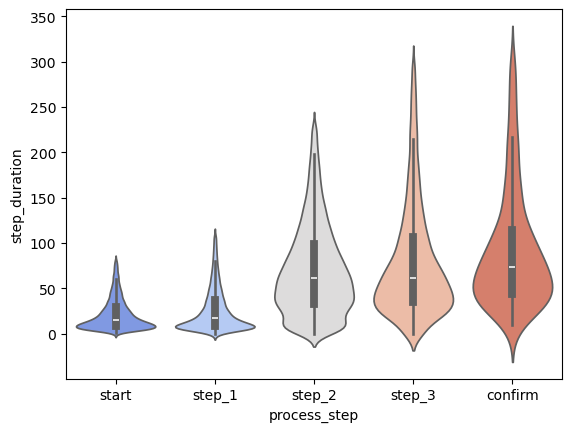

In [16]:
sns.violinplot(data=analysis_df[(analysis_df['Variation']=='Control') & (analysis_df['step_duration']<300)], y='step_duration', x='process_step', palette="coolwarm", hue='process_step', legend=False);

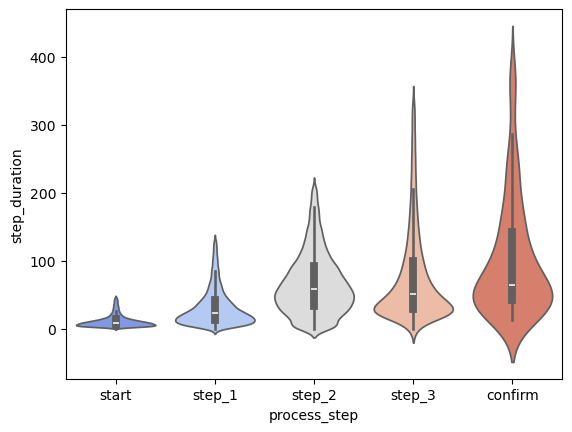

In [17]:
sns.violinplot(data=analysis_df[analysis_df['Variation']=='Test'], y='step_duration', x='process_step', palette="coolwarm", hue='process_step', legend=False);

In [18]:
pivot_df()

step_duration         step_proceeds       visit_final_step        \
Variation          Control    Test       Control  Test          Control  Test   
process_step                                                                    
start                21.07   11.75          0.64  0.66             0.36  0.33   
step_1               25.68   31.63          0.77  0.76             0.14  0.10   
step_2               70.59   66.72          0.83  0.80             0.07  0.05   
confirm             104.79  101.92          0.00  0.00             0.97  0.99   
step_3               81.35   76.63          0.70  0.75             0.10  0.08   

             step_error       other_issue       visit_id         
Variation       Control  Test     Control  Test  Control   Test  
process_step                                                     
start              0.00  0.00        0.00  0.00    24677  23881  
step_1             0.05  0.09        0.04  0.04    17351  19012  
step_2             0.05  0.08        0.06  0.06    14568  16261  
confirm            0.00  0.00        0.03  0.01    11779  15512  
step_3             0.10  0.07        0.09  0.10    13083  14619

In [19]:
error_visit_ids = list(analysis_df[(analysis_df['step_error'] == True)]['visit_id'].unique())
non_proceed_visit_ids = list(analysis_df[(analysis_df['step_proceeds'] == False) & (analysis_df['visit_final_step'] == False)]['visit_id'].unique())
total_visit_ids = list(analysis_df['visit_id'].unique())

In [20]:
# What proportion of visits have an error (go back to the previous step)
round(100 * len(error_visit_ids) / len(total_visit_ids),2)

10.7

In [21]:
# What proportion of visits had steps that didn't proceed as expected
round(100 * len(non_proceed_visit_ids) / len(total_visit_ids),2)

18.37

In [22]:
#What share of steps proceed / end the process / result in going back a step
step_proceeds_df = analysis_df[analysis_df['step_proceeds'] == True]
step_proceeds = analysis_df[['step_proceeds','visit_final_step', 'step_error']].mean() * 100
step_proceeds

step_proceeds       62.816954
visit_final_step    28.667715
step_error           4.355702
dtype: float64

In [23]:
#Set the hypothesis

#H0: control completion rate == test completion rate
#H1: control completion rate != test completion rate

alpha = 0.05

In [24]:
import numpy as np

# Assuming 'results' is the dataframe with the given data
test_visits = visit_df[visit_df['Variation'] == 'Test']
control_visits = visit_df[visit_df['Variation'] == 'Control']

# Calculate the number of successes (True values for 'successful_visit')
test_success = test_visits[test_visits['successful_visit'] == True].shape[0]
test_total = test_visits.shape[0]

control_success = control_visits[control_visits['successful_visit'] == True].shape[0]
control_total = control_visits.shape[0]

# Calculate the completion rates (proportions)
test_success_rate = test_success / test_total
control_success_rate = control_success / control_total

print(f"Test Completion Rate: {test_success_rate:.4f}")
print(f"Control Completion Rate: {control_success_rate:.4f}")

Test Completion Rate: 0.4204
Control Completion Rate: 0.4083


In [56]:
#Samples:
test_samples = [np.mean(np.random.choice(test_visits['successful_visit'], 100))for _ in range(500)]
control_samples = [np.mean(np.random.choice(control_visits['successful_visit'], 100))for _ in range(500)]

<function matplotlib.pyplot.show(close=None, block=None)>

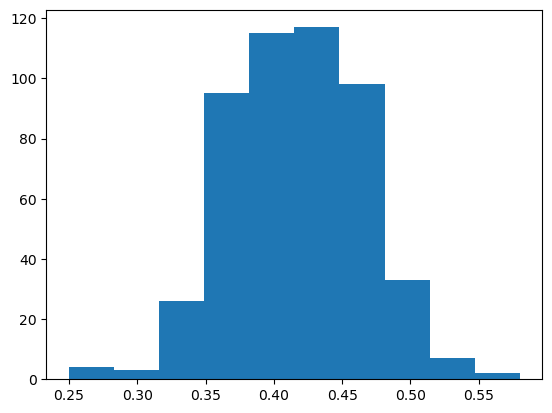

In [62]:
plt.hist(test_samples)
plt.show

(array([  3.,  17.,  29.,  74.,  69., 128., 101.,  46.,  26.,   7.]),
 array([0.27 , 0.296, 0.322, 0.348, 0.374, 0.4  , 0.426, 0.452, 0.478,
        0.504, 0.53 ]),
 <BarContainer object of 10 artists>)

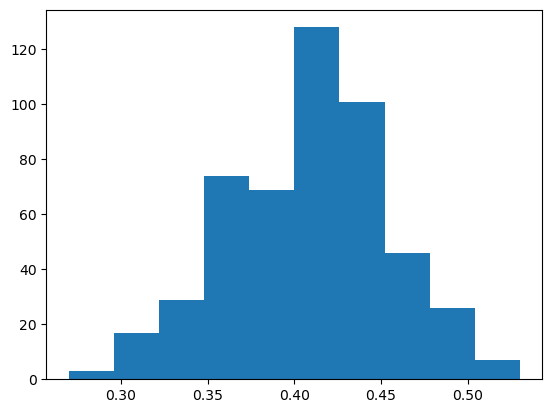

In [64]:
plt.hist(control_samples)
plt.show

In [66]:
st.ttest_ind(test_samples, control_samples, equal_var=False, alternative="two-sided")


TtestResult(statistic=3.0773512748878313, pvalue=0.0021455227027970276, df=997.0358160743571)

In [ ]:
#p-value is less than alpha (0.05)

In [70]:
success_df = visit_df[visit_df['successful_visit']==True]

In [80]:
success_df.head()

,visit_id,Variation,successful_visit,step_count,visit_duration
1,100019538_17884295066_43909,Test,True,9,226.0
2,100022086_87870757897_149620,Test,True,5,180.0
6,10006594_66157970412_679648,Control,True,7,354.0
10,100173292_91322748906_143563,Test,True,5,95.0
13,100254180_47139859079_984581,Control,True,5,341.0


In [82]:
test_success_durations = success_df[success_df['Variation'] == 'Test']['visit_duration']
control_success_durations = success_df[success_df['Variation'] == 'Control']['visit_duration']

# H0 test_success_duration mean != control_success_duration mean 

In [84]:
st.ttest_ind(test_success_durations, control_success_durations, equal_var=False, alternative="two-sided")

TtestResult(statistic=-21.415187271996018, pvalue=1.068813383895789e-100, df=21651.466976845586)

In [ ]:
#p-value is less than alpha (0.05)

<function matplotlib.pyplot.show(close=None, block=None)>

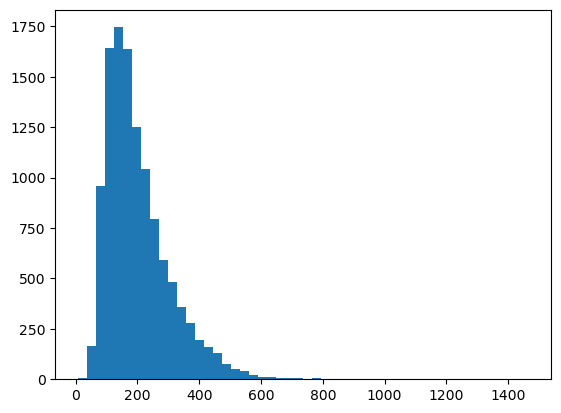

In [94]:
plt.hist(test_success_durations, bins=50)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

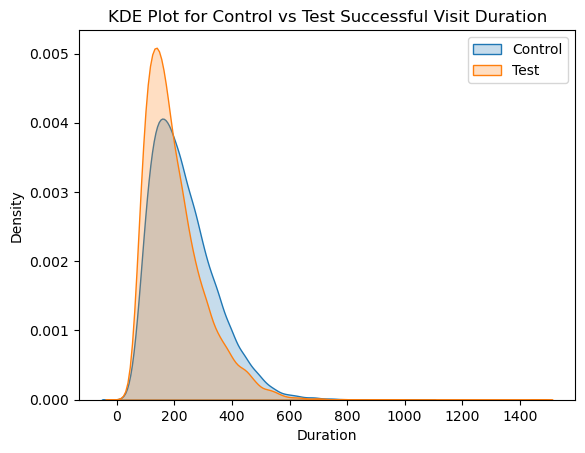

In [114]:
sns.kdeplot(control_success_durations, label='Control', fill=True)
sns.kdeplot(test_success_durations, label='Test', fill=True)

plt.xlabel('Duration')
plt.ylabel('Density')
plt.title('KDE Plot for Control vs Test Successful Visit Duration')
plt.legend()
plt.show

In [116]:
test_success_steps = success_df[success_df['Variation'] == 'Test']['step_count']
control_success_steps = success_df[success_df['Variation'] == 'Control']['step_count']

# H0 test_success_duration mean != control_success_duration mean 

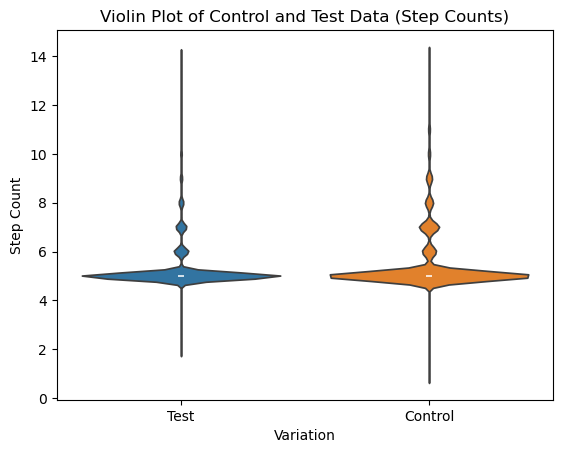

In [134]:
# Plotting the normalized histograms
# Combine the datasets into a single DataFrame for easier plotting
import pandas as pd

limit = success_df[success_df['step_count']< 15]
    
    # Create the violin plot
sns.violinplot(x='Variation', y='step_count', hue='Variation', data=limit)

# Adding labels and title
plt.ylabel('Step Count')
plt.title('Violin Plot of Control and Test Data (Step Counts)')

# Show the plot
plt.show()

In [136]:
success_df['over_4_steps'] = success_df['step_count'] > 4

C:\Users\olgeo\AppData\Local\Temp\ipykernel_23500\893607091.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_df['over_4_steps'] = success_df['step_count'] > 4


In [140]:
success_df.pivot_table(index='Variation',
                columns='over_4_steps',
                values='visit_id',
                aggfunc='count')

over_4_steps,False,True
Variation,,
Control,23,10555
Test,40,11655


In [217]:
analysis_df.head()

,client_id,visitor_id,visit_id,process_step,date_time,Variation,visit_final_step,step_duration,step_proceeds,step_error,other_issue
0,555,402506806_56087378777,637149525_38041617439_716659,start,2017-04-15 12:57:56,Test,False,7.0,True,False,False
1,555,402506806_56087378777,637149525_38041617439_716659,step_1,2017-04-15 12:58:03,Test,False,32.0,True,False,False
2,555,402506806_56087378777,637149525_38041617439_716659,step_2,2017-04-15 12:58:35,Test,False,99.0,True,False,False
3,555,402506806_56087378777,637149525_38041617439_716659,step_3,2017-04-15 13:00:14,Test,False,20.0,True,False,False
4,555,402506806_56087378777,637149525_38041617439_716659,confirm,2017-04-15 13:00:34,Test,True,NaN,False,False,False


In [227]:
test = successful_visit_col(analysis_df)
non_success_df = test[test['successful_visit']==False]

piv_df = non_success_df.pivot_table(index='process_step',
                                   columns='Variation',
                                   values='visit_final_step',
                                   aggfunc="mean")

piv_df
#piv_df[~piv_df['process_step']=='confirm']

Variation,Control,Test
process_step,,
confirm,0.894395,0.979518
start,0.624602,0.652217
step_1,0.319206,0.234841
step_2,0.242829,0.163255
step_3,0.508371,0.325377


<Axes: xlabel='process_step', ylabel='visit_final_step'>

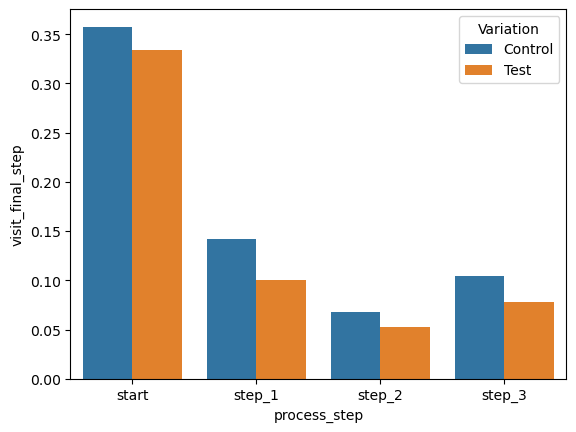

In [235]:
df = analysis_df[analysis_df['process_step']!='confirm']

piv_df = df.pivot_table(index='process_step',
                       columns='Variation',
                       values='visit_final_step',
                       aggfunc="mean").reset_index()

melt_df = piv_df.melt(id_vars='process_step',
                     value_vars = ['Control', 'Test'],
                     var_name = 'Variation',
                     value_name = 'visit_final_step')

sns.barplot(data=melt_df, x='process_step', y='visit_final_step', hue='Variation');

In [237]:
client_df.head()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,Variation,balance_quartile
0,169,21.0,262.0,47.5,M,2.0,501570.72,4.0,4.0,NaN,Q4
1,555,3.0,46.0,29.5,U,2.0,25454.66,2.0,6.0,Test,Q1
2,647,12.0,151.0,57.5,M,2.0,30525.80,0.0,4.0,Test,Q1
3,722,11.0,143.0,59.5,F,2.0,22466.17,1.0,1.0,NaN,Q1
4,934,9.0,109.0,51.0,F,2.0,32522.88,0.0,3.0,Test,Q1


In [239]:
analysis_client = pd.merge(analysis_df, client_df, on='client_id', how='left')

In [243]:
analysis_client.drop(columns=['Variation_y'],axis=1,inplace=True)

In [247]:
analysis_client.rename(columns={'Variation_x' : 'Variation'}, inplace=True)

In [249]:
analysis_client.head()

,client_id,visitor_id,visit_id,process_step,date_time,Variation,visit_final_step,step_duration,step_proceeds,step_error,other_issue,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,balance_quartile
0,555,402506806_56087378777,637149525_38041617439_716659,start,2017-04-15 12:57:56,Test,False,7.0,True,False,False,3.0,46.0,29.5,U,2.0,25454.66,2.0,6.0,Q1
1,555,402506806_56087378777,637149525_38041617439_716659,step_1,2017-04-15 12:58:03,Test,False,32.0,True,False,False,3.0,46.0,29.5,U,2.0,25454.66,2.0,6.0,Q1
2,555,402506806_56087378777,637149525_38041617439_716659,step_2,2017-04-15 12:58:35,Test,False,99.0,True,False,False,3.0,46.0,29.5,U,2.0,25454.66,2.0,6.0,Q1
3,555,402506806_56087378777,637149525_38041617439_716659,step_3,2017-04-15 13:00:14,Test,False,20.0,True,False,False,3.0,46.0,29.5,U,2.0,25454.66,2.0,6.0,Q1
4,555,402506806_56087378777,637149525_38041617439_716659,confirm,2017-04-15 13:00:34,Test,True,NaN,False,False,False,3.0,46.0,29.5,U,2.0,25454.66,2.0,6.0,Q1


In [269]:
visit_id_df = analysis_df[['visit_id', 'client_id']].drop_duplicates()

In [271]:
visit_client = pd.merge(visit_df, visit_id_df, on='visit_id', how='left')
visit_client = pd.merge(visit_client, client_df, on='client_id', how='left')

In [273]:
visit_client.columns

Index(['visit_id', 'Variation_x', 'successful_visit', 'step_count',
       'visit_duration', 'client_id', 'clnt_tenure_yr', 'clnt_tenure_mnth',
       'clnt_age', 'gendr', 'num_accts', 'bal', 'calls_6_mnth',
       'logons_6_mnth', 'Variation_y', 'balance_quartile'],
      dtype='object')

In [275]:
visit_client.drop(columns=['Variation_y'],axis=1,inplace=True)
visit_client.rename(columns={'Variation_x' : 'Variation'}, inplace=True)

In [285]:
visit_client.head()

,visit_id,Variation,successful_visit,step_count,visit_duration,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,balance_quartile
0,100012776_37918976071_457913,Test,False,1,0.0,3561384,4.0,56.0,59.5,U,2.0,63130.44,6.0,9.0,Q2
1,100019538_17884295066_43909,Test,True,9,226.0,7338123,7.0,88.0,23.5,M,2.0,26436.73,6.0,9.0,Q1
2,100022086_87870757897_149620,Test,True,5,180.0,2478628,16.0,198.0,47.0,F,2.0,32456.28,2.0,5.0,Q1
3,100030127_47967100085_936361,Control,False,1,0.0,105007,9.0,118.0,35.0,F,2.0,34897.47,3.0,6.0,Q1
4,100037962_47432393712_705583,Control,False,2,8.0,5623007,16.0,202.0,78.0,M,2.0,146827.14,5.0,8.0,Q4


In [283]:
# Is gendr similar between Test and Control

crosstab_res = pd.crosstab(visit_client['Variation'], visit_client['gendr'])

from scipy.stats import chi2_contingency

# Chi-square test for 'MSZoning' and 'SaleCondition'
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_res)

display(crosstab_res)
print(chi2_statistic, chi2_p_value)

# Not significant association between these values

gendr,F,M,U,X
Variation,,,,
Control,8408,8904,8708,0
Test,9090,9424,9416,1


2.3057098932986495 0.511427925646728


In [287]:
# Is success_rate similar between Test and Control

crosstab_res = pd.crosstab(visit_client['Variation'], visit_client['successful_visit'])

from scipy.stats import chi2_contingency

# Chi-square test for 'MSZoning' and 'SaleCondition'
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_res)

display(crosstab_res)
print(chi2_statistic, chi2_p_value)

# There is significant association between these values

successful_visit,False,True
Variation,,
Control,15340,10683
Test,16141,11801


7.6937292992417365 0.005541300915612427


In [ ]:
# Is age similar between Test and Control



In [ ]:
# Is clnt_tenure_mnth similar between Test and Control

In [ ]:
# Is bal similar between Test and Control